# Model Interpretation for Yolo Multitasks

Note that the code runs but you migh texperience some cuda out of memory issues. If it's the case, lower the hyper parameters in the captum calls.

from: https://github.com/pytorch/captum/blob/master/tutorials/Resnet_TorchVision_Interpret.ipynb

The interpretation algorithms that are used in this notebook are `Integrated Gradients` (w/ and w/o noise tunnel),  `GradientShap`, and `Occlusion`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.

In [6]:
from PIL import Image
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import torchvision
from torchvision import models
from torchvision import transforms
import captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import torch
from utils.general import check_img_size
from torch.nn import functional as F
import matplotlib.pyplot as plt
from models.common import DetectMultiBackend
from utils.torch_utils import select_device, smart_inference_mode
%matplotlib inline

## 1- Load the model


In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Loads pretrained Resnet model and sets it to eval mode

In [8]:
WEIGHTS_PATH = "runs/train-mlt/exp226/weights/last.pt"

model = DetectMultiBackend(WEIGHTS_PATH, dnn=False, fp16=False)
stride, pt, jit, engine = model.stride, model.pt, model.jit, model.engine
imgsz = check_img_size(512, s=stride)  # check image size
half = model.fp16  # FP16 supported on limited backends with CUDA
model.eval()

Fusing layers... 
YOLOv5s_mlt summary: 163 layers, 7697578 parameters, 0 gradients, 16.4 GFLOPs


DetectMultiBackend(
  (model): HybridModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
  

In [9]:
model = model.to(device)

In [10]:
model.__class__.__name__ = 'yolov5s_mlt_512'

## 2-Load the data

Defines transformers and normalizing functions for the image.

In [31]:
transform = transforms.Resize([512,512])
img_path = '/home/selim/Desktop/datasets/data_road_cond_seq_split_2/val/images/20210629_173500_2327.jpg'
img = Image.open(img_path).convert('RGB')
img = np.asarray(img, dtype="float")
print(type(img))
img = img = img /255
img_tensor = torch.from_numpy(img).to(model.device).permute(2,0,1)
img_tensor = transform(img_tensor)
img_tensor = img_tensor.unsqueeze(0).float()
img_tensor.shape

<class 'numpy.ndarray'>


torch.Size([1, 3, 512, 512])

In [32]:
class_names = ['dry', 'snowy', 'wet']
idx_to_labels = ['dry', 'snowy', 'wet']

Predict the class of the input image

In [33]:
y_test = model(img_tensor.to(device))
(pred, cls_pred) = y_test
output = F.softmax(cls_pred, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = class_names[pred_label_idx]
print('Predicted:', predicted_label,"with confidence:", round(prediction_score.squeeze().item(),3))


Predicted: dry with confidence: 0.996


In [34]:
pred_label_idx.cpu()

tensor(0)

In [35]:
img_tensor = img_tensor.to(device)

## 3- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [36]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(img_tensor, target=pred_label_idx, n_steps=30)





Predicted: dry ( 0.9955014586448669 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

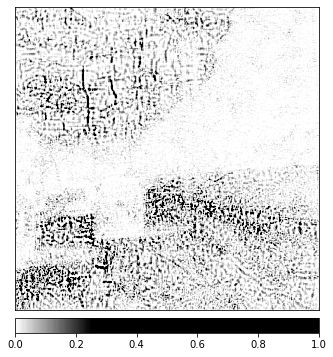

In [37]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

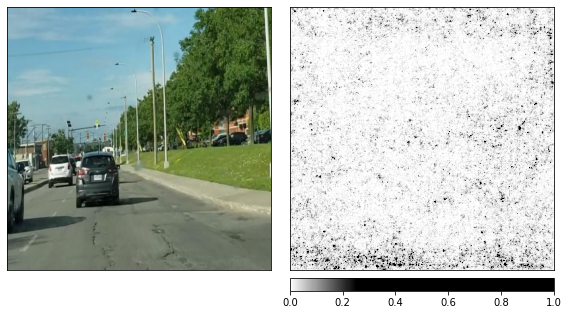

In [38]:
integrated_gradients = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(img_tensor, nt_samples=1, n_steps=10, 
                                            nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

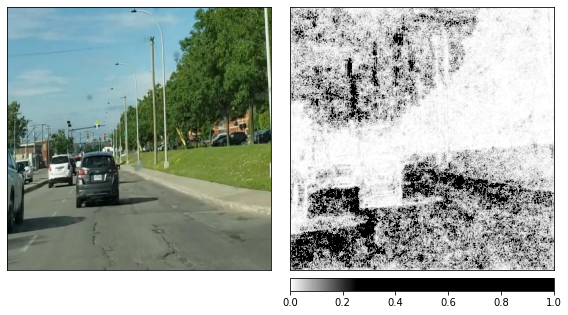

In [39]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([img_tensor * 0, img_tensor * 1])

attributions_gs = gradient_shap.attribute(img_tensor,
                                          n_samples=10,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## 4- Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [40]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img_tensor.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

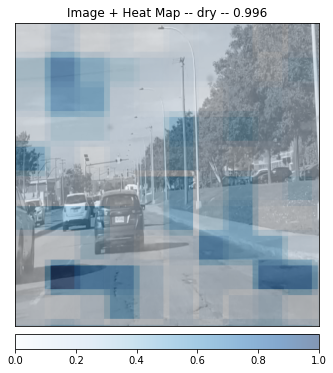

In [41]:
occlusion = Occlusion(model)

# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )
_ = viz.visualize_image_attr(
        np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        show_colorbar=True,
        method='blended_heat_map',
        outlier_perc=2,
        title="Image + Heat Map -- " + str(predicted_label) + " -- " + str(round(prediction_score.squeeze().item(),3)),
        use_pyplot=True
    )

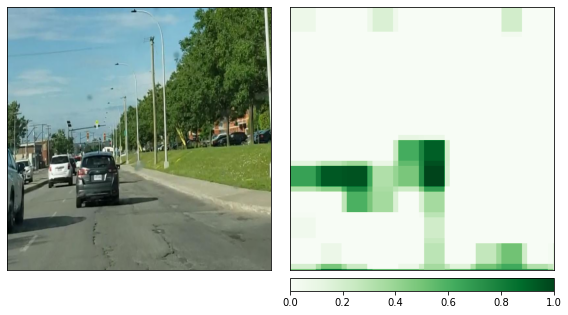

In [42]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
